<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#set-parameters" data-toc-modified-id="set-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>set parameters</a></span></li><li><span><a href="#Parse-Lammps-dump-file" data-toc-modified-id="Parse-Lammps-dump-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parse Lammps dump file</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>main()</a></span></li></ul></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train NN</a></span></li></ul></div>

# import libs

In [123]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.pyplot.rc('text', usetex=True)
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# set parameters

In [2]:
#--- set dynamic parameters
temp = confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


# Parse Lammps dump file

In [3]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = 1) #sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

output dump file=3.3496668338775635 s
parsing dumpFile/dump.xyz
elapsed time=0.15659189224243164 s
time steps: dict_keys([0, 1])


,id,type,x,y,z
0,1,1,0.353697,10.973928,10.974073
1,2,1,21.593906,12.743907,23.363878
2,3,1,18.054001,21.594000,7.434096
3,4,1,10.974410,16.283590,19.823591
4,5,1,19.823940,5.664172,3.894208


OSError: ../simulations/niNatom1KTemp1000K/Run0/Diffusion.dat not found.

# Energy

In [4]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,
                 events_directory,evlist_directory,
                 lmpData,
                 nmax = sys.maxsize,
                 verbose=False):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        self.box = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))

        #--- soap parameters
        self.species = ['Ni'] #'Ni Co Cr'.split()
        self.r_cut = 3.0 #4.1
        self.n_max = 8
        self.l_max = 6
        #
        self.nmax = np.min(np.array([nmax,sys.maxsize]))
        self.verbose = verbose
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog          = self.ParseEvList_dir()
        self.diffusionPaths   = self.ParseDiffusionPath()
        
        
    def ParseEvents_dir(self):
        '''
        return energy barriers associated with hopping events
        '''
        if self.verbose:
            print('parsing events ...')
        files = os.listdir(self.events_dir)
        d=[]
        count = 0
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
                    #
                    if count > self.nmax:
                        break
                    count += 1
                except:
#                    traceback.print_exc()
                    continue
            
        #--- extract types
        df       = self.lmpData
        atom_ids = d[:,1]
        types    = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    @staticmethod
    def ReadConfigurationFile(dumpFile, outpt, outpt_headers):
        '''
        return displacements
        '''
#        !rm outpt outpt_headers
        lib_path = confParser['input files']['lib_path']

        #--- parse dump: call ovito
        !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers

        #--- parse dump files
        lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        lmpData.GetCords( ncount = sys.maxsize)

        #--- disp
        fileCurr = fileRef = outpt #'dumpFile/dump.xyz'
        outpt = 'disp.xyz'
#        !rm $outpt

        #--- call ovito
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))

        #--- parse disp files
        lmpDisp = lp.ReadDumpFile( outpt )
        lmpDisp.GetCords( ncount = sys.maxsize )
        return lmpDisp

    @staticmethod
    def GetEventid(filestr):
        '''
        extract event id from input string
        '''
        n = len(filestr)
        return int(filestr[5:n-4])
    
    def ParseDiffusionPath(self):
        '''
        return diffusion path corresponding to hopping events
        '''
        if self.verbose:
            print('parsing ParseDiffusionPath ...')
        disps = {}
        count = 0
        files = os.listdir(self.events_dir)
        self.events_id_energy
        for event_id in list(map(int,self.events_id_energy.event_id)):
#        for sfile in files:
#            if '.xyz' in sfile: #--- skip .xyz files 
#                try:
                    dumpFile = '%s/event%s.xyz'%(self.events_dir,event_id) #--- open file
                    #         outpt = 'dumpFile/dump.xyz'
#                    event_id = EnergyBarrier.GetEventid(sfile)
                    disps[event_id] = \
                    EnergyBarrier.ReadConfigurationFile(dumpFile, 'dump.xyz', 'calcResults.txt')
                    if self.verbose:
                        print('event_id=%s'%(event_id))
                    #
                    if count > self.nmax:
                        break
                    count += 1
#                 except:
#                     traceback.print_exc()
#                     continue
        return disps
    
    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

    def SetDescriptors(self): #, event_id):
        
#        positions = self.diffusionPaths[event_id].coord_atoms_broken[0]['x y z'.split()]
        positions = self.perAtomData['x y z'.split()]

        #--- convert to lammps data file
        atom = lp.Atoms(**self.perAtomData['id type x y z'.split()].to_dict(orient='series'))
        wd = lp.WriteDataFile(atom, self.box, {1:1,2:1,3:1}) #--- modify!!
        wd.Write('lammps.dat')

#        center_atom_type = self.diffusionPaths[event_id].coord_atoms_broken[0]['type'].iloc[-1]
        
        #--- load configuration
        atoms = ase.io.read("lammps.dat",format="lammps-data",style='atomic')


        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

        


        # set atomic numbers for each species
        types=atoms.get_atomic_numbers()
        numbers = list(map(lambda x:soap.index_to_atomic_number[x-1],atoms.get_atomic_numbers()))
        atoms.set_atomic_numbers(numbers)
        numbers = atoms.get_atomic_numbers()
        #assert soap.check_atomic_numbers(atoms.get_atomic_numbers())

        #--- center atom is the last entry
        self.descriptors = soap.create( atoms) #,centers=[atoms.get_number_of_atoms()-1])
        
#        pdb.set_trace()

        count = 0
        nspecies = len(self.species)
        for Z in range(nspecies):#atoms.get_atomic_numbers():
            for Zprime in range(nspecies): #atoms.get_atomic_numbers():
                for l in range(self.l_max+1):
                    for n in range(self.n_max):
                        for nprime in range(self.n_max):
                            if nprime >= n and Zprime >= Z:
                                count += 1
        assert count == self.descriptors[0].shape[0], 'count = %s, soap.shape=%s'%(count,self.descriptors[0].shape[0])

#        return soap_descriptors #[0]
    
    
#     def SetDescriptorsMultipleEvents(self):
#         events = list(self.diffusionPaths.keys())
#         self.descriptors = np.c_[list(map(lambda x:self.SetDescriptors(x), events))]
        
    def DefectFreeCrystal(self):
        '''
        Return a crystalline structure
        '''
        # Lets create an FCC(111) surface
        a=2.5*2**0.5
        atoms = ase.build.fcc100(
            "Ni",
             (16,16,16),
            a=a,
    #        vacuum=10,
            periodic=True
        )

        atoms.pop(i=-1)
        
        lammpsdata.write_lammps_data('junk.dat', atoms )
        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

        #--- center atom is the last entry
        self.descriptors_defect_free = soap.create( atoms ) #,centers=[0])[0]

    def LabelDefects(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        df = self.lmpData.copy()


        #--- modify dataframe
        df['energy_barrier']=np.inf
        df['defect_label']=0
        df['ux']=0.0
        df['uy']=0.0
        df['uz']=0.0

        #--- defective atoms: add relevant columns
        defective_atom_ids = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd = utl.FilterDataFrame(df,key='id',
                                        val=defective_atom_ids,
                                        )
        #--- energy
        energy = self.events_id_energy.barrier

        #--- disps
        event_ids = self.events_id_energy['event_id']
        config_no = 2 #--- relaxed conf
        loc_center = -1  #--- center
        keys = 'DisplacementX DisplacementY DisplacementZ'.split()
        disps=\
        np.concatenate(list(map(lambda x:
                                np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
                                event_ids)))

        #--- add columns
        keys = 'id type x y z'.split()
        df_mod = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                              columns=keys+'ux uy uz energy_barrier defect_label'.split()
                             )

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated = utl.FilterDataFrame(df,key='id',
                                        val=crystalline_atom_ids,
                                        )

        data_concat = np.concatenate([np.c_[df_mod],np.c_[df_negated]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=list(df_mod.keys())
                             )
        
    def LabelDefectsUpdated(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        df = self.lmpData.copy()


        #--- modify dataframe
        df['energy_barrier']=np.inf
        df['defect_label']=0
        df['ux']=0.0
        df['uy']=0.0
        df['uz']=0.0

        #--- defective atoms: add relevant columns
        kmc_step = 1
        defective_atom_ids = np.c_[self.catalog[ kmc_step ][ 'AtomId' ]].astype(int).flatten()
#        defective_atom_ids = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd = utl.FilterDataFrame(df,key='id',
                                        val=defective_atom_ids,
                                        )
        #--- energy
        energy = self.catalog[ kmc_step ][ 'barrier' ]

        #--- disps
        event_ids = np.c_[self.catalog[ kmc_step ][ 'eventId' ]].astype(int).flatten()
        config_no = 2 #--- relaxed conf
        loc_center = -1  #--- center
        keys = 'DisplacementX DisplacementY DisplacementZ'.split()
        disps=\
        np.concatenate(list(map(lambda x:
                                np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
                                event_ids)))

        #--- add columns
        keys = 'id type x y z'.split()
        df_mod = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                              columns=keys+'ux uy uz energy_barrier defect_label'.split()
                             )

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated = utl.FilterDataFrame(df,key='id',
                                        val=crystalline_atom_ids,
                                        )

        data_concat = np.concatenate([np.c_[df_mod],np.c_[df_negated]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=list(df_mod.keys())
                             )

## main()

In [6]:
def main():
    if not eval(confParser['EnergyBarrier']['EnergyBarrier']):
        return
    
    eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                       lmpData,
                       nmax = 2, #100,
                       verbose = True,

                      )
    

    eb.Parse()
    #eb.events_id_energy extract from Events_dir
    #eb.energyByType extract from catalogs
    
    eb.LabelDefectsUpdated()
    
    #--- setup descriptors
    eb.SetDescriptors() #MultipleEvents()

    #--- 
#    eb.DefectFreeCrystal()    

    return eb
data = main()

parsing events ...
file=event697406 atom_id=286
file=event697407 atom_id=72
parsing ParseDiffusionPath ...
event_id=697406
event_id=697407


In [7]:
data.perAtomData.iloc[:13]

,id,type,x,y,z,ux,uy,uz,energy_barrier,defect_label
0,9.0,1.0,16.305105,9.204,10.995106,-0.000006,-1.727032,-1.727043,0.996860,1.0
1,72.0,1.0,16.305105,10.952895,12.744001,-0.000006,-1.727032,-1.727043,0.996860,1.0
2,286.0,1.0,18.054001,10.952895,14.492895,-0.000006,-1.727032,-1.727043,0.996860,1.0
3,423.0,1.0,18.054001,7.455105,10.995106,-0.000006,-1.727032,-1.727043,0.996860,1.0
4,487.0,1.0,19.802895,9.204,10.995106,-0.000006,-1.727032,-1.727043,0.996860,1.0
5,520.0,1.0,16.305105,7.455105,12.744001,-0.000006,-1.727032,-1.727043,0.996860,1.0
6,742.0,1.0,18.054001,10.952895,10.995106,-0.000006,-1.727032,-1.727043,0.996860,1.0
7,750.0,1.0,19.802895,7.455105,12.744001,-0.000006,-1.727032,-1.727043,0.996860,1.0
8,1024.0,1.0,19.802895,10.952895,12.744001,-0.000006,-1.727032,-1.727043,0.996860,1.0
9,1033.0,1.0,16.305105,9.204,14.492895,-0.000006,-1.727032,-1.727043,0.996860,1.0


In [76]:
data.descriptors.shape

(1371, 252)

# Train NN

## pca

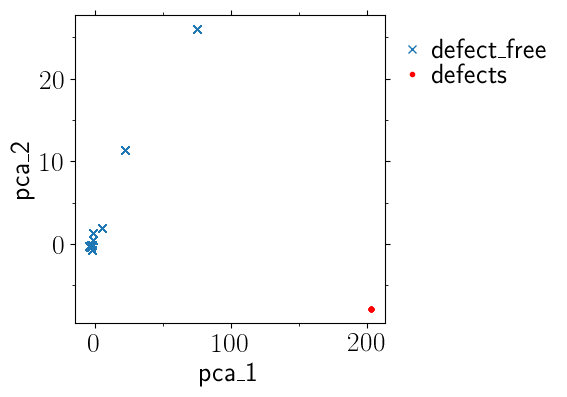

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

In [78]:
def zscore(slist):
    tmp = np.copy(slist)
    print(np.mean(tmp),np.std(tmp))
    tmp -= np.mean(tmp)
    tmp /= np.std(tmp)
    return tmp

#--- concat. data
X = data.descriptors

pca = PCA(n_components=2,random_state=123)
pca.fit(X)
X_transformed = pca.transform(X)

xdata = X_transformed[:,0]
ydata = X_transformed[:,1]
#
filtr_defects = data.perAtomData.defect_label == 0.0
#

legend = utl.Legends()
legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
          attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                Plot = False,
#                 xlim=(-2,2),
#                 ylim=(-2,2),
          )

#utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
          attrs={'fmt':'.','color':'red','label':'defects'},
           ax=ax,
           xstr='pca_1',ystr='pca_2',
           legend = legend.Get(),
           title='png/pca.png'
          )

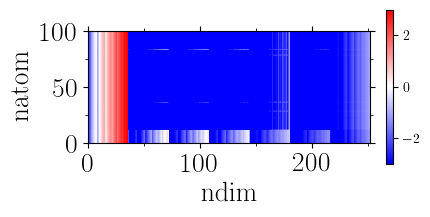

In [121]:
m=100 #data.descriptors.shape[0]
utl.PltBitmap(np.log10(np.abs(data.descriptors[:m,:])),
              xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
              xlim=(0,data.descriptors.shape[1]),
              ylim=(0,m),
              colorbar=True,
              zscore=False,
              vminmax=(-3,3),
              title='png/feature_bitmap.png'
             
             )

## train

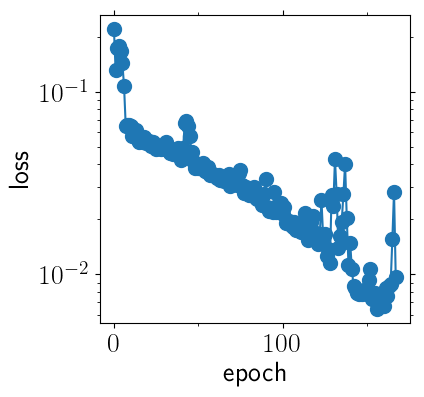

cm= [[340   0]
 [  0   3]]


In [151]:
#--- train-test split
y = np.c_[data.perAtomData.defect_label].astype(int)
X = np.c_[data.descriptors]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=1)

#--- tune parameters
param_grid = {
                'hidden_layer_sizes':[(100,100)],
#                 'activation' : ['tanh', 'relu'],
                 'learning_rate_init':[1e-4],
#                'alpha':[1e-4,1e-3,1e-2], #--- regularization 
#               'learning_rate' : ['invscaling', 'adaptive'],
                
             } 

#--- train
mlp = MLPClassifier(random_state=1)
clf = GridSearchCV(mlp, param_grid)
clf.fit(X_train,y_train)

#--- validate
utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
           yscale='log',
           xstr='epoch',ystr='loss',
           title='png/loss.png',
          )


#--- confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test),
                 labels=[0, 1]
                )
print('cm=',cm)


In [132]:
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network._multilayer_perceptron:

class MLPClassifier(sklearn.base.ClassifierMixin, BaseMultilayerPerceptron)
 |  MLPClassifier(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity

cm= [[1019    0]
 [   9    0]]


In [10]:
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network._multilayer_perceptron:

class MLPClassifier(sklearn.base.ClassifierMixin, BaseMultilayerPerceptron)
 |  MLPClassifier(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity

In [149]:
filtr_defects = data.perAtomData.defect_label == 1.0

X, y = data.descriptors[filtr_defects], np.c_[data.perAtomData['energy_barrier'][filtr_defects]] #make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,)# random_state=1)
regr = MLPRegressor(max_iter=500).fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)


        

<AxesSubplot:xlabel='$E_\\mathrm{act}$', ylabel='$E_\\mathrm{pred}$'>

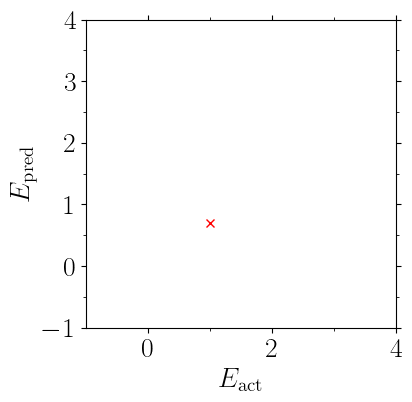

In [150]:
ax = utl.PltErr(None,None,Plot=False)

utl.PltErr(y_test,y_pred_test,
           attrs={'fmt':'.','color':'C0'},
           ax=ax,
           Plot=False,
          )

utl.PltErr(y_train,y_pred_train,
           attrs={'fmt':'x','color':'red'},
           ax=ax,
           Plot=False
          )

utl.PltErr(None,None,
          xlim=(-1,4),
          ylim=(-1,4),
           xstr=r'$E_\mathrm{act}$',
           ystr=r'$E_\mathrm{pred}$',
           ax=ax,
           Plot=False
          )
